In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
# Custom library for Censored GP
import GPy

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [ ]:
"""
In order to use custom optimizers for the training of Censored Models it is important to have 
installed the 'climin' package for optimization. Alternatively, you can consider using different 
optimizers already packaged in GPy. However, the results in Section 4.2.1 were obtained through 
the Adam optimizer (packaged in climin)
"""
try:
    import climin
except:
    !pip install climin
    import climin

In [2]:
plt.style.use("ggplot")

As a working example let's replicate results for the Synthetic Dataset shown in Section 4.1.1:

### Toy data construction 

_Let's define the experimental design for an effective observation/understanding of the censoring issue:_

1. _Given the underlying function $f(x) = 2 + 0.5\sin{(2x)} + \frac{x}{10}$ we sample 100 equally spaced noisy observations between $x=0$ and $x=10$._

2. _Generate censored versions of the observations defined in 1. The censoring will be characterized by (i) Number of censored points out of the 100 samples (ii) Censoring intensity_

3. _Fit both Gaussian and Censored GP to the data and observe model fit + record performances_

In [3]:
"""Data is generated as follows:
- Define latent function f(x) = 2 + 0.5*sin(2x) + x/10
- Generetae observations from the latent function y_obs (assuming some small observation noise, let's focus on censoring)
- Select the points in the oscillation peaks. 
- Apply a p_c% manual censoring to those points sampled uniformly between [0.2, 0.3] for all selected points.
"""

np.random.seed(10)
# Define underlying function
x = np.linspace(0, 10, 100)
y_true = 0.5*np.sin(2*x) + 2 + x/10

# Generate noisy observations
y_obs = y_true + np.random.normal(loc=0, scale=0.1, size=x.shape[0])
y_cens = copy.deepcopy(y_obs)

# Select random points as censored and apply p% censoring
censoring = np.int32(0.5*np.sin(2*x) + 2 >= 2) 
p_c = np.random.uniform(low=0.2, high=0.3, size=np.sum(censoring==1))
y_cens[censoring == 1] = y_obs[censoring == 1]*(1-p_c)

In [4]:
# Standardize the data
scaler = StandardScaler()
y_cens_sc = scaler.fit_transform(y_cens.reshape(-1,1))
y_true_sc = scaler.transform(y_true.reshape(-1,1))

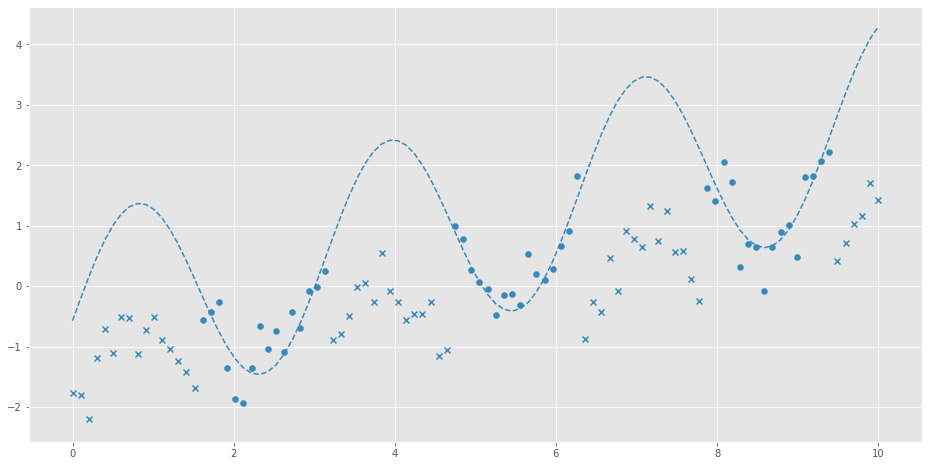

In [5]:
plt.figure(figsize=(16,8))
plt.plot(x, y_true_sc, linestyle="--", label="True function", color='#348ABD')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens_sc[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens_sc[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');

## Models

The training scheme can be summarized as follows:
1. Define the kernel
2. Build the model
3. Optimize
4. Generate predictions

For simplicity we will assume to use an RBF Kernel for both Censored and Non-Censored GPs

**1) Non Censored GP (NCGP)**

In [14]:
"""Define kernel"""
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [15]:
"""Build model.

GPRegression assumes Gaussian Likelihood (no censoring here).
"""
gp = GPy.models.GPRegression(X=x.reshape(-1,1), Y=y_cens_sc.reshape(-1,1), kernel=kernel)

In [16]:
"""Optimize

For the case of Gaussian Likelihood we will use BFGS as an optimization algorithm.

The optimization regards the kernel hyper-parameters as well as the likelihood noise.
"""
gp.optimize(optimizer="BFGS", max_iters=5000, messages=True)

In [17]:
"""Predict

Obtain posterior samples from the GP latent variable f. We then compute the mean and 95% Confidence Interval for our predictions.
"""
f_gaus_samples = gp.posterior_samples_f(X=x.reshape(-1,1), size=10000)
f_gaus_mean = np.mean(f_gaus_samples, axis=2)
f_gaus_025 = np.quantile(a=f_gaus_samples, q=0.025, axis=2).reshape(-1,)
f_gaus_975 = np.quantile(a=f_gaus_samples, q=0.975, axis=2).reshape(-1,)

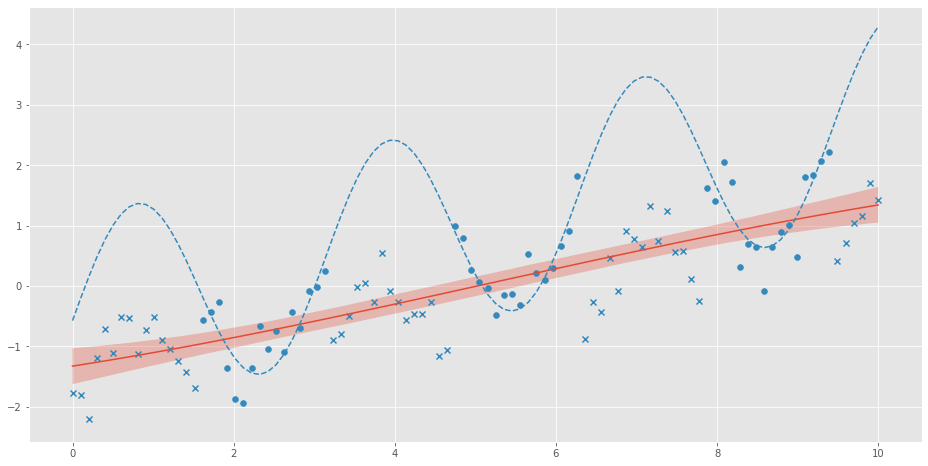

In [18]:
# Plot predictions
plt.figure(figsize=(16,8))
plt.plot(x, f_gaus_mean, label="GP Prediction")
plt.fill_between(x, f_gaus_025, f_gaus_975, alpha=0.3)
plt.plot(x, y_true_sc, linestyle="--", label="True function")
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens_sc[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens_sc[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');

**2) Non Censored GP - Aware (NCGP-A)**

In [20]:
"""Define kernel"""
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [21]:
"""Build model.

GPRegression assumes Gaussian Likelihood (no censoring here).
"""
gp = GPy.models.GPRegression(X=x[censoring==0].reshape(-1,1), Y=y_cens_sc[censoring==0].reshape(-1,1), kernel=kernel)

In [22]:
"""Optimize

For the case of Gaussian Likelihood we will use BFGS as an optimization algorithm.

The optimization regards the kernel hyper-parameters as well as the likelihood noise.
"""
gp.optimize(optimizer="BFGS", max_iters=5000, messages=True)

In [23]:
"""Predict

Obtain posterior samples from the GP latent variable f. We then compute the mean and 95% Confidence Interval for our predictions.
"""
f_gaus_samples = gp.posterior_samples_f(X=x.reshape(-1,1), size=10000)
f_gaus_mean = np.mean(f_gaus_samples, axis=2)
f_gaus_025 = np.quantile(a=f_gaus_samples, q=0.025, axis=2).reshape(-1,)
f_gaus_975 = np.quantile(a=f_gaus_samples, q=0.975, axis=2).reshape(-1,)

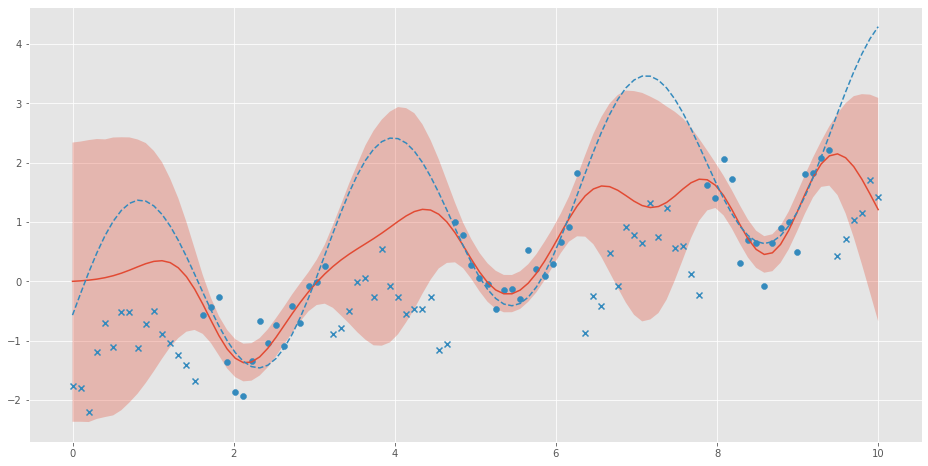

In [24]:
# Plot predictions
plt.figure(figsize=(16,8))
plt.plot(x, f_gaus_mean, label="GP Prediction")
plt.fill_between(x, f_gaus_025, f_gaus_975, alpha=0.3)
# plt.plot(X, y_pred_main, label="True function", linestyle="--")
plt.plot(x, y_true_sc, linestyle="--", label="True function")
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens_sc[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens_sc[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');

**3) Censored GP (CGP)**

In [6]:
"""Define kernel"""
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [29]:
"""Build model.

GPCensoredRegression assumes Censored Likelihood as define in Section 3.

The GPCensoredRegression model requires two additional arguments compared to the GPRegression showed above:
    - censoring: a binary vector indicating which observations in the input data are to be considered as censored (1 for censored, 0 for non censored)
    - likelihood: since we are moving away from a Gaussian likelihood setting we need to use the custom 'CensoredGaussian Likelihood' (which also requires the 'censoring' vector)
"""
gp = GPy.models.GPCensoredRegression(X=x.reshape(-1,1), Y=y_cens_sc.reshape(-1,1), censoring=censoring, kernel=kernel, likelihood=GPy.likelihoods.CensoredGaussian(censoring=censoring, variance=0.1))

defaulting to <GPy.inference.latent_function_inference.expectation_propagation.EPCensored object at 0x000001A31A1CD2B0> for latent function inference


In [34]:
"""Optimize

For the case of Censored Likelihood we will use Adam as an optimization algorithm.

The optimization regards the kernel hyper-parameters as well as the likelihood noise.
"""
gp.optimize(optimizer="adam", max_iters=2500, messages=True)

In [27]:
"""Predict

Obtain posterior samples from the GP latent variable f. We then compute the mean and 95% Confidence Interval for our predictions.
"""
f_gaus_samples = gp.posterior_samples_f(X=x.reshape(-1,1), size=10000)
f_gaus_mean = np.mean(f_gaus_samples, axis=2)
f_gaus_025 = np.quantile(a=f_gaus_samples, q=0.025, axis=2).reshape(-1,)
f_gaus_975 = np.quantile(a=f_gaus_samples, q=0.975, axis=2).reshape(-1,)

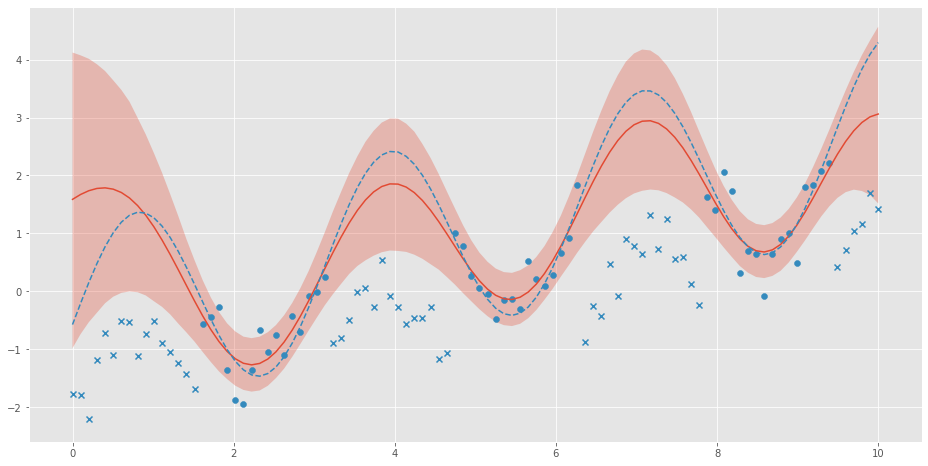

In [28]:
# Plot predictions
plt.figure(figsize=(16,8))
plt.plot(x, f_gaus_mean, label="GP Prediction")
plt.fill_between(x, f_gaus_025, f_gaus_975, alpha=0.3)
# plt.plot(X, y_pred_main, label="True function", linestyle="--")
plt.plot(x, y_true_sc, linestyle="--", label="True function")
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens_sc[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens_sc[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');